# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [22]:
# импортирование библиотек
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None

In [23]:
data = pd.read_csv('/datasets/Churn.csv')

In [24]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [25]:
data.tail(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9990,9991,15798964,Nkemakonam,714,Germany,Male,33,3.0,35016.60,1,1,0,53667.08,0
9991,9992,15769959,Ajuluchukwu,597,France,Female,53,4.0,88381.21,1,1,0,69384.71,1
9992,9993,15657105,Chukwualuka,726,Spain,Male,36,2.0,0.00,1,1,0,195192.40,0
9993,9994,15569266,Rahman,644,France,Male,28,7.0,155060.41,1,1,0,29179.52,0
9994,9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


**Документация к данным**
  
*Признаки*
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
   
*Целевой признак*
- `Exited` — факт ухода клиента

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть пропуски в колонке Tenure, можно заполнить значения средним по столбцу.

In [27]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

В данных нет особого разброса значений: пропуски можно заполнить значением 5, что является одновременно и средним, и медианой.

In [28]:
data['Tenure'] = data['Tenure'].fillna(value=data['Tenure'].median())
data['Tenure'].isna().sum()

0

Колонка Tenure содержит целые числа, поэтому преобразуем к типу int.

In [29]:
data['Tenure'] = data['Tenure'].astype('int')
data['Tenure'].dtypes

dtype('int64')

Колонки RowNumber, CustomerId и Surname - уникальные значения, они не подойдут в качестве признаков для обучения, поэтому их нужно удалить.

In [30]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Преобразуем категориальные признаки в количественные техникой прямого кодирования.

In [31]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Числовые признаки имеют разный масштаб - применим стандартизацию.

In [32]:
# делим данные на обучающую, валидационную и тестовую выборки и стандартизируем числовые признаки
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

features_train, features_vt, target_train, target_vt = train_test_split(features, target, random_state=12345, test_size=0.4)
features_valid, features_test, target_valid, target_test = train_test_split(features_vt, target_vt, random_state=12345, test_size=0.5)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0


In [33]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


Признаки готовы к обучению.

## Исследование задачи

### Логистическая регрессия

In [34]:
# обучим модель логистической регрессии и найдём значение F1 меры
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))
print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))

F1: 0.33108108108108103
Матрица ошибок:
 [[1506   76]
 [ 320   98]]


### Решающее дерево

In [35]:
# обучим модель решающего дерева и найдём значение F1 меры
best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)

F1: 0.5696969696969697
Глубина дерева: 6


### Случайный лес

In [36]:
%%time
# обучим модель случайного леса и найдём значение F1 меры
best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 10):
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_depth = depth
            best_f1 = f1 
            best_est = est 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)
print('Количество деревьев:', best_est)

F1: 0.5999999999999999
Глубина дерева: 14
Количество деревьев: 9
CPU times: user 4.04 s, sys: 27.3 ms, total: 4.06 s
Wall time: 4.07 s


#### Вывод

Без учёта баланса классов были обучены три модели:   
Логистическая регрессия: 0.33   
Решающее дерево: 0.57  
Случайный лес: 0.6  
  
На данном этапе лучший результат показал случайный лес с глубиной дерева 14 и количеством деревьев 9.

## Борьба с дисбалансом

Проверим баланс классов.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

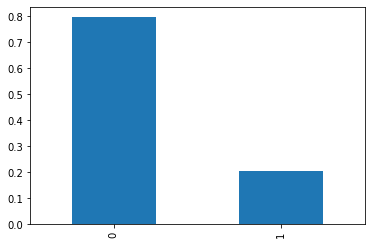

In [37]:
# подсчёт классов в целевом признаке
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar')

В выборке наблюдается дисбаланс: положительных объектов около 20%.

Для каждой модели применим три техники перебалансировки: взвешивание классов, upsampling, downsampling, и выберем лучший результат.

In [38]:
# функция увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [39]:
# функция уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

### Логистическая регрессия

In [40]:
# добавим в логистическую регрессию взвешивание классов и найдём значение F1 меры
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4888507718696398


Взвешивание классов в логистической регрессии улучшило F1 метрику с 0.33 до почти 0.49.

In [41]:
# применим к логистической регрессии технику upsampling и найдём значение F1 меры
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5


С помощью техники upsampling значение F1 метрики удалось поднять до 0.5.

In [42]:
# применим к логистической регрессии технику downsampling и найдём значение F1 меры
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.504875406283857


С помощью техники downsampling F1 метрику удалось улучшить ещё на тысячные доли.

Попробуем менять порог классификации.

In [43]:
# рассчитываем вероятности положительного класса
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('Вероятность положительного класса первых пяти объектов:', probabilities_one_valid[:5])
print('Средняя вероятность положительного класса:', probabilities_one_valid.mean())

Вероятность положительного класса первых пяти объектов: [0.32088589 0.2883222  0.39507869 0.23447781 0.34328035]
Средняя вероятность положительного класса: 0.3527506505013175


In [44]:
# перебираем значение порога и для каждого находим точность, полноту и F1-меру
for threshold in np.arange(0, 0.6, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.04 | Точность = 0.210, Полнота = 1.000, F1 = 0.347
Порог = 0.06 | Точность = 0.214, Полнота = 1.000, F1 = 0.353
Порог = 0.08 | Точность = 0.221, Полнота = 0.995, F1 = 0.361
Порог = 0.10 | Точность = 0.229, Полнота = 0.990, F1 = 0.372
Порог = 0.12 | Точность = 0.235, Полнота = 0.976, F1 = 0.379
Порог = 0.14 | Точность = 0.245, Полнота = 0.964, F1 = 0.391
Порог = 0.16 | Точность = 0.252, Полнота = 0.938, F1 = 0.397
Порог = 0.18 | Точность = 0.262, Полнота = 0.931, F1 = 0.409
Порог = 0.20 | Точность = 0.273, Полнота = 0.916, F1 = 0.420
Порог = 0.22 | Точность = 0.282, Полнота = 0.890, F1 = 0.428
Порог = 0.24 | Точность = 0.291, Полнота = 0.876, F1 = 0.437
Порог = 0.26 | Точность = 0.306, Полнота = 0.849, F1 = 0.450
Порог = 0.28 | Точность = 0.325, Полнота = 0.842, F1 = 0.469
Порог = 0.30 | Точность = 0.336, Полнота = 0.821, F1 = 0.477
Порог = 0.32 | Точность 

Максимальное значение F1 метрики достигается при пороге 0.5 - значит, порог менять не нужно.

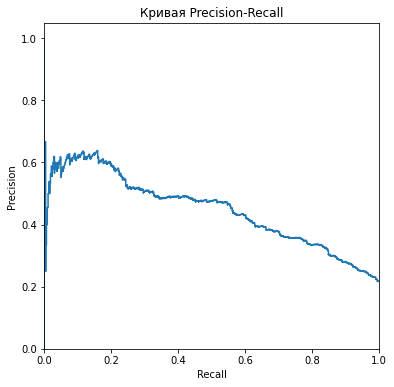

In [45]:
# строим PR-кривую
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Проверим модель на адекватность.

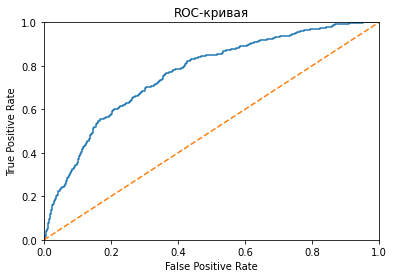

In [46]:
# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [47]:
# вычисляем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

AUC-ROC: 0.7625666136378758


Метрика AUC-ROC: 0.76. Лучше, чем у случайной модели, но до идеала ещё далеко.   
Лучший результат модели логистической регрессии: 0.5048  
Перебалансировка: downsampling   
Порог: 0.5

### Решающее дерево

In [48]:
# добавим в решающее дерево взвешивание классов и найдём значение F1 меры
best_depth = 0
best_f1 = 0
best_model = None 

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1 
        best_model = model

print('F1:', best_f1)
print('Глубина дерева:', best_depth)

F1: 0.5963791267305644
Глубина дерева: 5


Взвешивание классов в решающем дереве улучшило F1 метрику с 0.569 до 0.596.

In [49]:
# применим к решающему дереву технику upsampling и найдём значение F1 меры
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)

F1: 0.5963791267305644
Глубина дерева: 5


Техника увеличения выборки не изменила метрику.

In [50]:
# применим к решающему дереву технику downsampling и найдём значение F1 меры
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth = depth
        best_f1 = f1 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)

F1: 0.579212916246216
Глубина дерева: 5


Техника уменьшения выборки ухудшила метрику с 0.596 до 0.579. Значит, остановимся на варианте с взвешиванием классов.

In [51]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.5963791267305644


Попробуем менять порог классификации.

In [52]:
# рассчитываем вероятности положительного класса
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('Вероятность положительного класса первых пяти объектов:', probabilities_one_valid[:5])
print('Средняя вероятность положительного класса:', probabilities_one_valid.mean())

Вероятность положительного класса первых пяти объектов: [0.02910316 0.67540834 0.4552828  0.2444974  0.12251352]
Средняя вероятность положительного класса: 0.3875970292726538


In [53]:
# перебираем значение порога и для каждого находим точность, полноту и F1-меру
for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.208, Полнота = 0.995, F1 = 0.345
Порог = 0.02 | Точность = 0.208, Полнота = 0.995, F1 = 0.345
Порог = 0.04 | Точность = 0.238, Полнота = 0.978, F1 = 0.383
Порог = 0.06 | Точность = 0.238, Полнота = 0.978, F1 = 0.383
Порог = 0.08 | Точность = 0.238, Полнота = 0.978, F1 = 0.383
Порог = 0.10 | Точность = 0.238, Полнота = 0.978, F1 = 0.383
Порог = 0.12 | Точность = 0.238, Полнота = 0.978, F1 = 0.383
Порог = 0.14 | Точность = 0.253, Полнота = 0.962, F1 = 0.401
Порог = 0.16 | Точность = 0.263, Полнота = 0.955, F1 = 0.412
Порог = 0.18 | Точность = 0.264, Полнота = 0.947, F1 = 0.413
Порог = 0.20 | Точность = 0.295, Полнота = 0.928, F1 = 0.448
Порог = 0.22 | Точность = 0.295, Полнота = 0.928, F1 = 0.448
Порог = 0.24 | Точность = 0.295, Полнота = 0.928, F1 = 0.448
Порог = 0.26 | Точность = 0.335, Полнота = 0.878, F1 = 0.485
Порог = 0.28 | Точность = 0.335, Полнота = 0.878, F1 = 0.485
Порог = 0.30 | Точность = 0.335, Полнота = 0.878, F1 = 0.485
Порог = 0.32 | Точность 

Порог 0.58 увеличивает F1 метрику до 0.608.

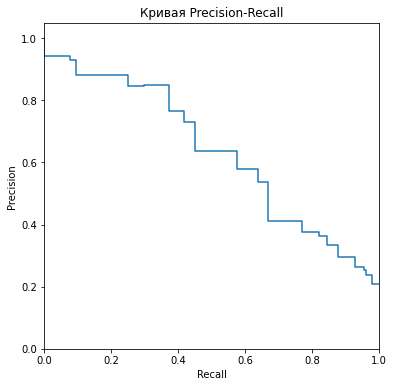

In [54]:
# строим PR-кривую
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

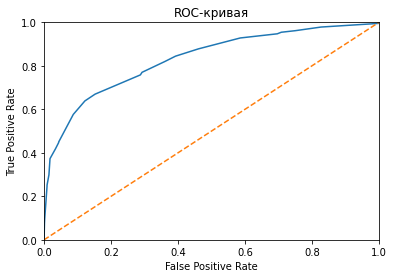

In [55]:
# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [56]:
# вычисляем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

AUC-ROC: 0.8310244134068074


Метрика AUC-ROC: 0.83. Лучше, чем у случайной модели и у логистической регрессии.   
Лучший результат модели решающего дерева: 0.608  
Перебалансировка: взвешивание классов  
Порог: 0.58

### Случайный лес

In [57]:
%%time
# добавим в случайный лес взвешивание классов и найдём значение F1 меры
best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 10):
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_depth = depth
            best_f1 = f1 
            best_est = est 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)
print('Количество деревьев:', best_est)

F1: 0.6288770053475936
Глубина дерева: 7
Количество деревьев: 7
CPU times: user 4.14 s, sys: 11.9 ms, total: 4.15 s
Wall time: 4.16 s


Благодаря взвешиванию классов, F1 метрика улучшилась с 0.599 до 0.628.

In [58]:
%%time
# применим к решающему дереву технику upsampling и найдём значение F1 меры
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 10):
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_depth = depth
            best_f1 = f1 
            best_est = est 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)
print('Количество деревьев:', best_est)

F1: 0.631578947368421
Глубина дерева: 10
Количество деревьев: 9
CPU times: user 4.37 s, sys: 59.9 ms, total: 4.43 s
Wall time: 4.44 s


Техника upsampling помогла улучшить метрику с 0.628 до 0.63.

In [59]:
%%time
# применим к случайному лесу технику downsampling и найдём значение F1 меры
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 11):
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_depth = depth
            best_f1 = f1 
            best_est = est 

print('F1:', best_f1)
print('Глубина дерева:', best_depth)
print('Количество деревьев:', best_est)

F1: 0.6288416075650118
Глубина дерева: 6
Количество деревьев: 10
CPU times: user 3.48 s, sys: 58.5 ms, total: 3.53 s
Wall time: 3.65 s


Техника upsampling справилась лучше всего.

In [60]:
model = RandomForestClassifier(n_estimators=9, max_depth=10, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.631578947368421


Попробуем менять порог классификации.

In [61]:
# рассчитываем вероятности положительного класса
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('Вероятность положительного класса первых пяти объектов:', probabilities_one_valid[:5])
print('Средняя вероятность положительного класса:', probabilities_one_valid.mean())

Вероятность положительного класса первых пяти объектов: [0.06466489 0.72141821 0.35710351 0.14146999 0.0499318 ]
Средняя вероятность положительного класса: 0.2716803329785571


In [62]:
# перебираем значение порога и для каждого находим точность, полноту и F1-меру
for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.02 | Точность = 0.217, Полнота = 0.998, F1 = 0.357
Порог = 0.04 | Точность = 0.239, Полнота = 0.990, F1 = 0.385
Порог = 0.06 | Точность = 0.252, Полнота = 0.971, F1 = 0.401
Порог = 0.08 | Точность = 0.267, Полнота = 0.950, F1 = 0.417
Порог = 0.10 | Точность = 0.281, Полнота = 0.926, F1 = 0.431
Порог = 0.12 | Точность = 0.295, Полнота = 0.919, F1 = 0.447
Порог = 0.14 | Точность = 0.317, Полнота = 0.907, F1 = 0.470
Порог = 0.16 | Точность = 0.334, Полнота = 0.876, F1 = 0.483
Порог = 0.18 | Точность = 0.353, Полнота = 0.849, F1 = 0.499
Порог = 0.20 | Точность = 0.379, Полнота = 0.844, F1 = 0.523
Порог = 0.22 | Точность = 0.394, Полнота = 0.830, F1 = 0.535
Порог = 0.24 | Точность = 0.419, Полнота = 0.804, F1 = 0.551
Порог = 0.26 | Точность = 0.434, Полнота = 0.778, F1 = 0.557
Порог = 0.28 | Точность = 0.462, Полнота = 0.761, F1 = 0.575
Порог = 0.30 | Точность = 0.476, Полнота = 0.739, F1 = 0.579
Порог = 0.32 | Точность 

Порог 0.44 даёт лучший результат: 0.638.

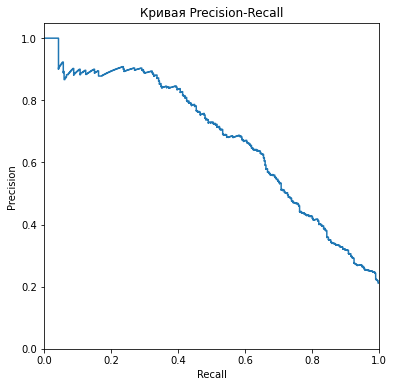

In [63]:
# строим PR-кривую
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

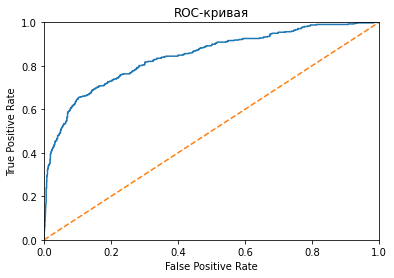

In [64]:
# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [65]:
# вычисляем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

AUC-ROC: 0.8438980093032259


Метрика AUC-ROC: 0.84. Лучше, чем у случайной модели, логистической регрессии и решающего дерева.   
Лучший результат модели случайного леса: 0.638  
Перебалансировка: upsampling   
Порог: 0.44

#### Вывод

Подведём итоги:   

- Логистическая регрессия: 0.5048
- Решающее дерево: 0.608
- Случайный лес: 0.638  
   
Для тестирования выбираем модель случайного леса с количеством деревьев 9, глубиной 10 и порогом 0.44.

## Тестирование модели

In [66]:
%%time
# объединим обучающую и валидационную выборки в одну обучающую, обучим лучшую модель и получим F1-меру для тестовой выборки
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

model = RandomForestClassifier(n_estimators=9, max_depth=10, random_state=12345)
model.fit(features_upsampled, target_upsampled)

threshold = 0.44

predicted_proba = model.predict_proba(features_test)
predicted_test = (predicted_proba[:,1] >= threshold).astype('int')

print('F1:', f1_score(target_test, predicted_test))

F1: 0.6201183431952664
CPU times: user 97.7 ms, sys: 0 ns, total: 97.7 ms
Wall time: 114 ms


In [67]:
# рассчитываем вероятности положительного класса
probabilities_one_test = predicted_proba[:,1]
print('Вероятность положительного класса первых пяти объектов:', probabilities_one_test[:5])
print('Средняя вероятность положительного класса:', probabilities_one_test.mean())

Вероятность положительного класса первых пяти объектов: [0.07833657 0.37036231 0.11379332 0.03629222 0.06011475]
Средняя вероятность положительного класса: 0.2724571289196063


In [68]:
# вычисляем AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('AUC-ROC:', auc_roc)

AUC-ROC: 0.8458080174374242


#### Вывод

Метрика AUC-ROC: почти 0.85. Даже лучше, чем на валидационной выборке.      
Лучший результат модели случайного леса: 0.62  
Перебалансировка: upsampling   
Порог: 0.44

Метрика AUC-ROC: 0.84. Лучше, чем у случайной модели, логистической регрессии и решающего дерева.   
Лучший результат модели случайного леса: 0.638  
Перебалансировка: upsampling   
Порог: 0.44